In [1]:
import causalpy as cp
import plotnine as pn
import polars as pl
import statsmodels.formula.api as smf

In [2]:
res = pl.read_parquet("outputs/model_eval/2024-09-11T15-25-00/pythia-9M-bpe32000.parquet")

In [3]:
res = res.filter(pl.col("input_ids").list.len() > 1)

In [37]:
thres = 32_000
pdata = (
    res.filter((pl.col("new_token_id") > thres - 20) & (pl.col("new_token_id") < thres + 20))
    # From surprisal to loglikelihood
    .with_columns(loglik=pl.col("sup").list.eval(pl.element().neg()))
    .with_columns(
        y=(
            pl.when(pl.col("new_token_id") >= thres)
            .then(pl.col("loglik").list.sum())
            .otherwise(pl.col("loglik").list.get(-1))
        )
    )
    .select(["new_token_id", "y"])
    .group_by("new_token_id")
    .agg(pl.col("y").mean())
    .with_columns(x=pl.col("new_token_id") / 1_000, treated=pl.col("new_token_id") >= thres)
    .drop("new_token_id")
    .to_pandas()
)
pdata.head()

,y,x,treated
0,-7.148821,31.987,False
1,-3.984506,31.998,False
2,-6.923713,32.004,True
3,-8.531574,31.984,False
4,-8.976953,32.009,True


In [38]:
# Fit model
rdd = smf.ols("y ~ x + treated + x:treated", pdata).fit(cov_type="HC3")

# Compute discontinuity at threasold
discontinuity_at_threshold = rdd.predict({"x": [31.999, 32.0], "treated": [False, True]}).to_dict()
discontinuity_at_threshold = discontinuity_at_threshold[1] - discontinuity_at_threshold[0]

In [39]:
rdd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.065
Method:                 Least Squares   F-statistic:                    0.1861
Date:                Wed, 11 Sep 2024   Prob (F-statistic):              0.905
Time:                        17:05:03   Log-Likelihood:                -89.855
No. Observations:                  39   AIC:                             187.7
Df Residuals:                      35   BIC:                             194.4
Df Model:                           3                                         
Covariance Type:                  HC3                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1323.2400   4954.643      0.267      0.789   -8387.681     1.1e+04
treated[T.True]     356.1620   5730.564      0.062      0.950   -1.09e+04    1.16e+04
x                   -41.5948    154.875     -0.269      0.788    -345.145     261.955
x:treated[T.True]   -11.1141    179.105     -0.062      0.951    -362.153     339.924
==============================================================================
Omnibus:                        4.327   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.115   Jarque-Bera (JB):                3.520
Skew:                           0.623   Prob(JB):                        0.172
Kurtosis:                       2.218   Cond. No.                     4.89e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 4.89e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
pdata.groupby("treated")["y"].std()

treated
False    2.652175
True     2.353094
Name: y, dtype: float64

In [41]:
simple_mean = pdata.groupby("treated")["y"].mean().to_dict()
simple_mean[True] - simple_mean[False]

-0.4064271210337438

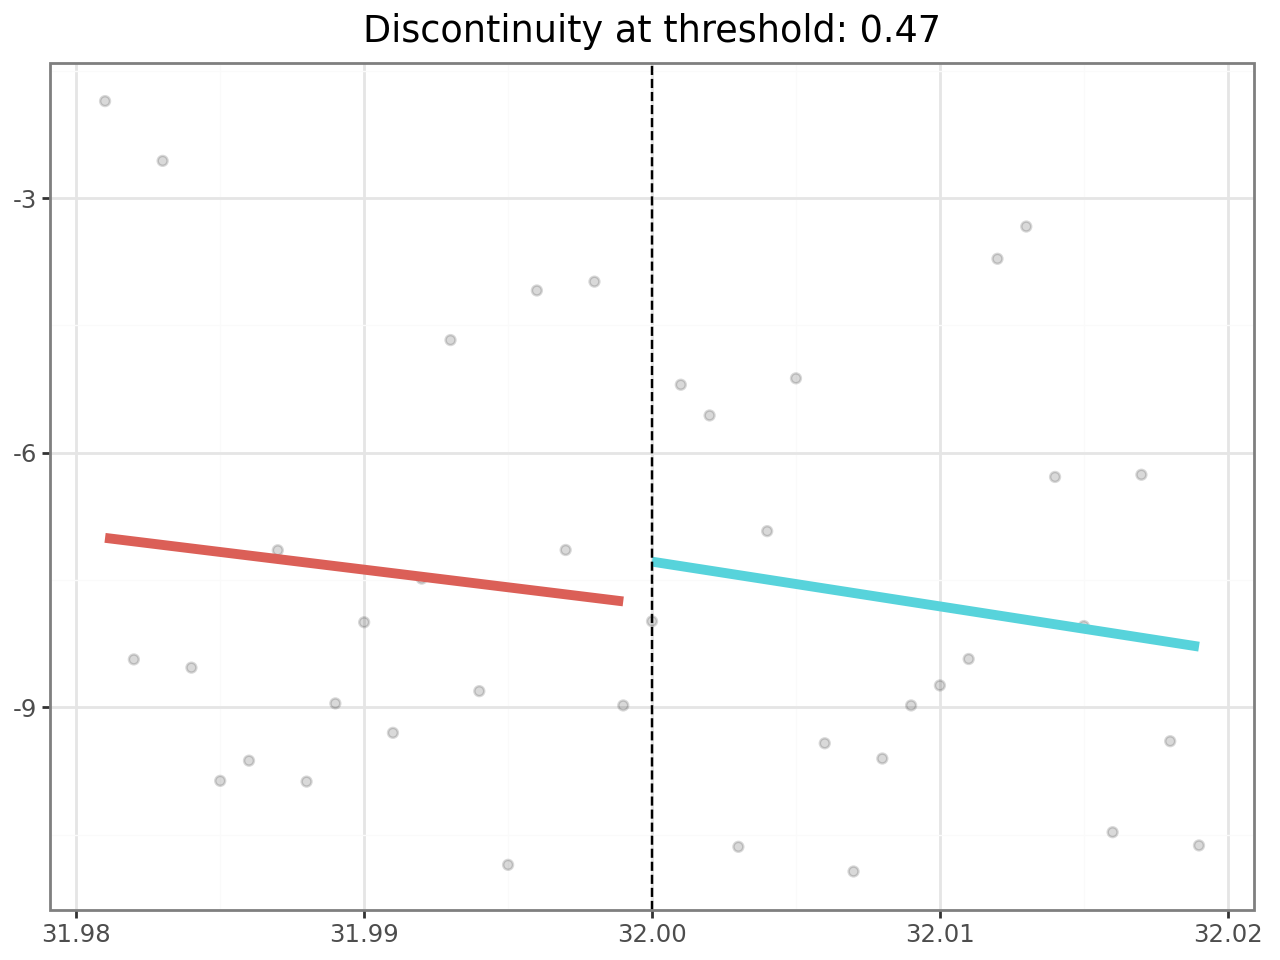

In [42]:
p = (
    pn.ggplot(pdata, pn.aes(x="x", y="y"))
    + pn.geom_point(alpha=0.15)
    + pn.geom_line(pn.aes(y=rdd.fittedvalues, color="treated"), size=2)
    +
    # pn.coord_cartesian(ylim=(4, 12)) +
    pn.geom_vline(xintercept=32.0, linetype="dashed", color="black")
    + pn.labs(x="", y="", colour="", title=f"Discontinuity at threshold: {discontinuity_at_threshold:.2f}")
    + pn.scale_colour_discrete(guide=None)
    + pn.theme_bw()
    # pn.scale_y_log10()
)

p

----

In [56]:
result = cp.RegressionDiscontinuity(
    data=pdata,
    formula="y ~ 1 + x + treated + x:treated",
    model=LinearRegression(),
    treatment_threshold=32000.0,
    running_variable_name="x",
)

# fig, ax = result.plot()

(<Figure size 720x480 with 1 Axes>,
 <Axes: title={'center': '$R^2$ on all data = 0.064\nDiscontinuity at threshold = 0.88'}, xlabel='x', ylabel='y'>)

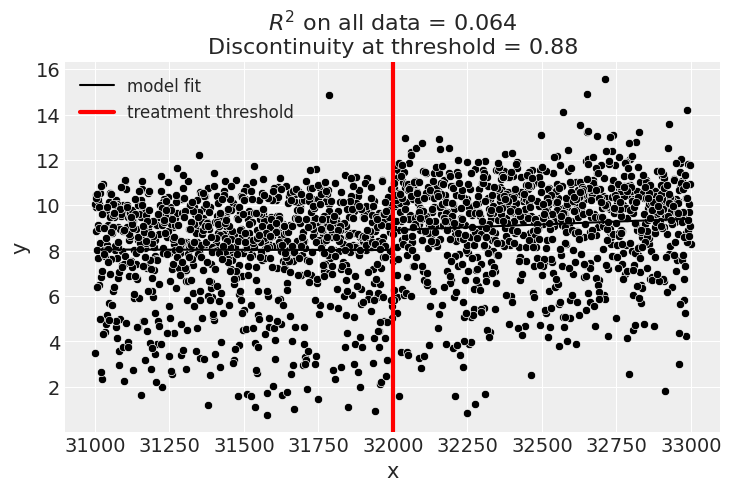

In [13]:
result.plot()

In [ ]:
(pn.ggplot(pdata, pn.aes("new_token_id", "tok_sup")) + pn.geom_point())